The segmentation of lung structures is very challenging problem because homogeneity is not present in the lung region, similar densities in the pulmonary structures, different scanners and scanning protocols. The segmented lungs can be further used to find the lung nodule candidates and regions of interest which may help in better classification of the CT Scans. Finding the lung nodule regions is a very hard problem because there are nodules that are attached to the blood vessels or are present at the boundary of the lung region. The lung nodule candidates can be further used for classification by cutting 3D voxels around them and passing it through a 3D CNNs which can be trained on LUNA16 dataset. The LUNA 16 dataset has the location of the nodules in each CT Scan thus will be useful for training the classifier. 

In this tutorial, we will first segment the lungs and then find the region of interest in the CT Scans using Image processing methods. Then I will talk about how to preprocess LUNA16 dataset for training architectures like UNet for segmentation.

**Reading a CT Scan**
-----------------
Each CT Scan consists of multiple 2D slices which are provided in a DICOM format. At first, I will read the random dicom file of a CT Scan. After reading the image file, we will update the intensity values of -2000 with 0 because they are the pixels that fall outside of the scanner bounds.

sample_images
stage1_labels.csv
stage1_sample_submission.csv



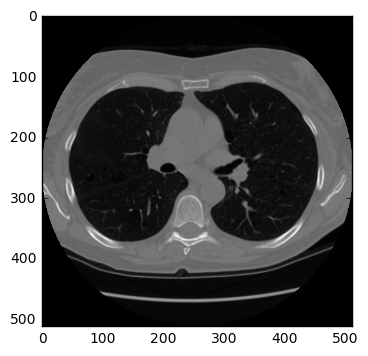

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import numpy as np

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
lung = dicom.read_file('../input/sample_images/00cba091fa4ad62cc3200a657aeb957e/38c4ff5d36b5a6b6dc025435d62a143d.dcm')

slice = lung.pixel_array
slice[slice == -2000] = 0
plt.imshow(slice, cmap=plt.cm.gray)

Now we will read all the dicom slices for a scan and then stack them with respect to their Instance Number to get the 3D Lung CT Scanned Image.

In [2]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

In [3]:
ct_scan = read_ct_scan('../input/sample_images/00cba091fa4ad62cc3200a657aeb957e/') 

Now we will plot a few more images of the slices using the *plot_ct_scan* function.

In [4]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

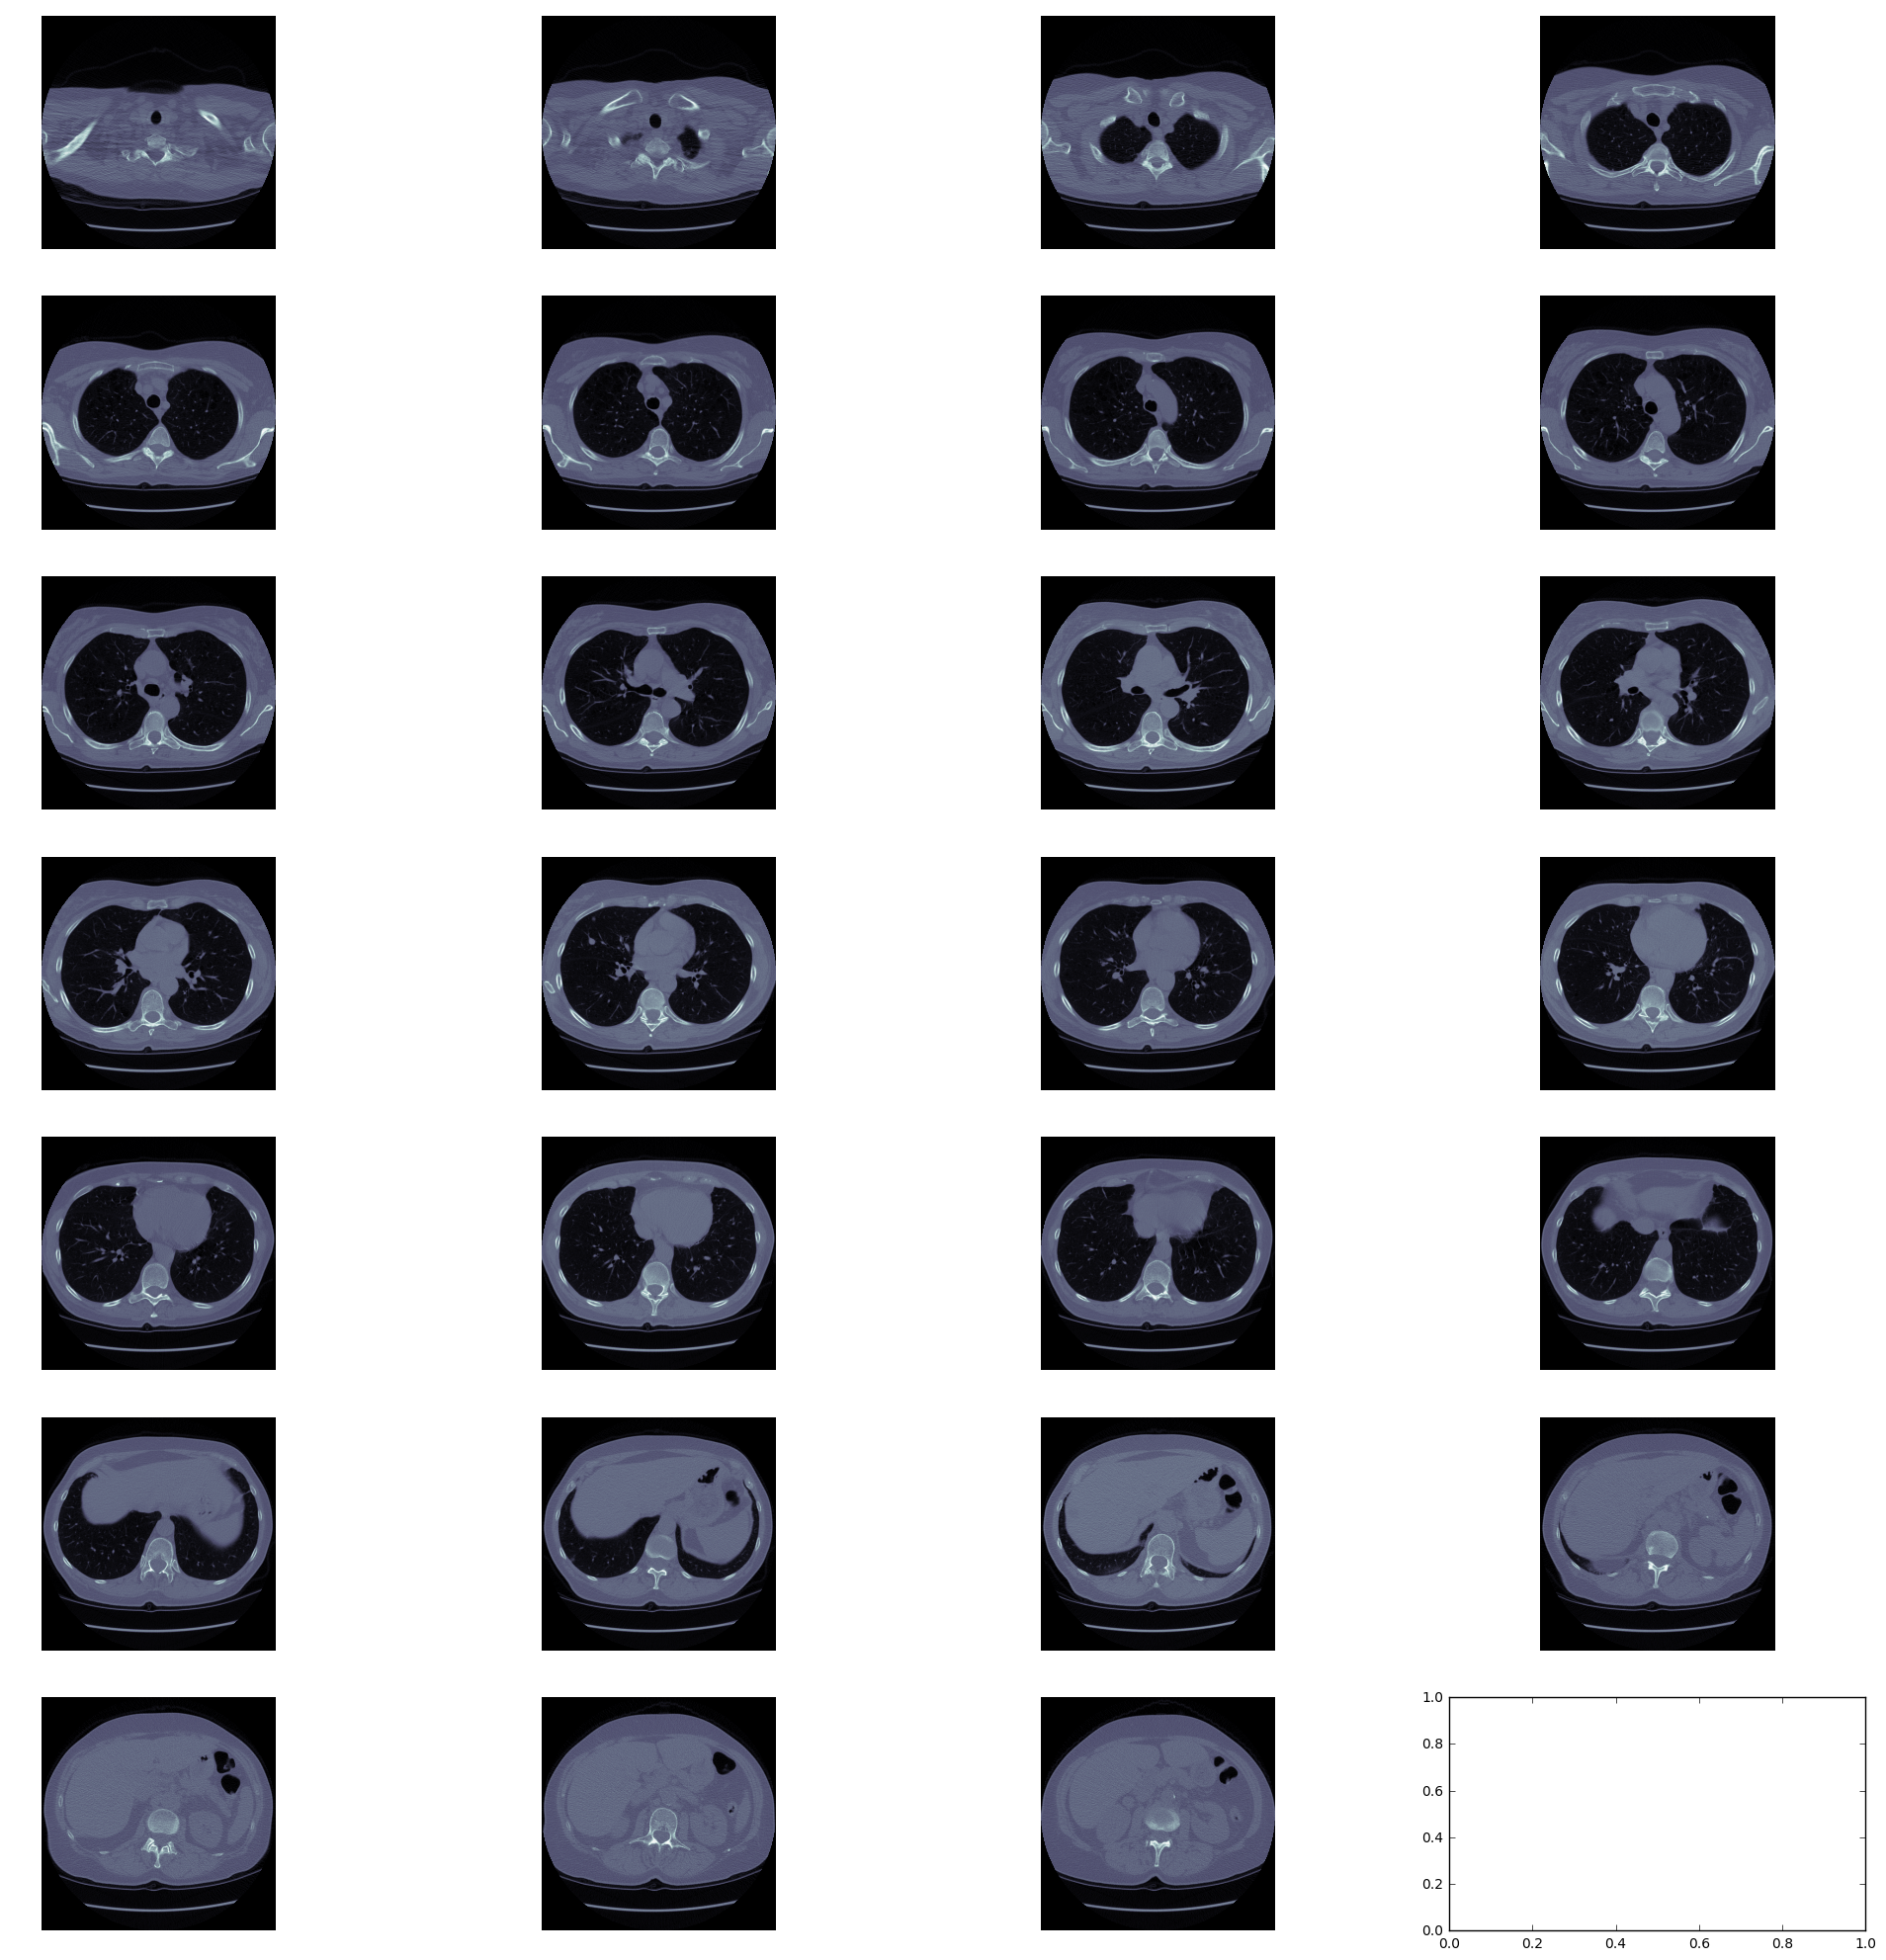

In [5]:
plot_ct_scan(ct_scan)

## Segmentation of Lungs ##
After reading the CT Scan, the first step in preprocessing is the segmentation of lung structures because it is obvious that the regions of interests lies inside the lungs. A threshold of 604(-400 HU) is used at all places because it was found in experiments that it works just fine. We segment lung structures from each slice of the CT Scan image and try not to loose the possible region of interests attached to the lung wall. 

In [6]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

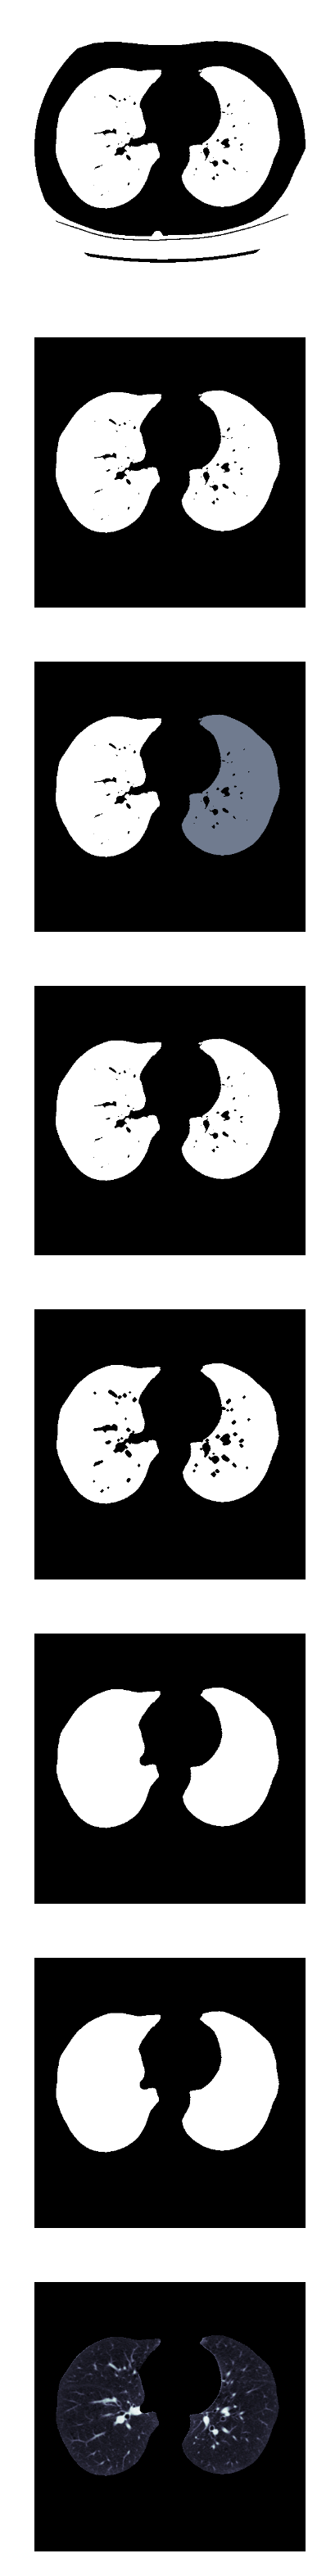

In [7]:
get_segmented_lungs(ct_scan[71], True)

In [8]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

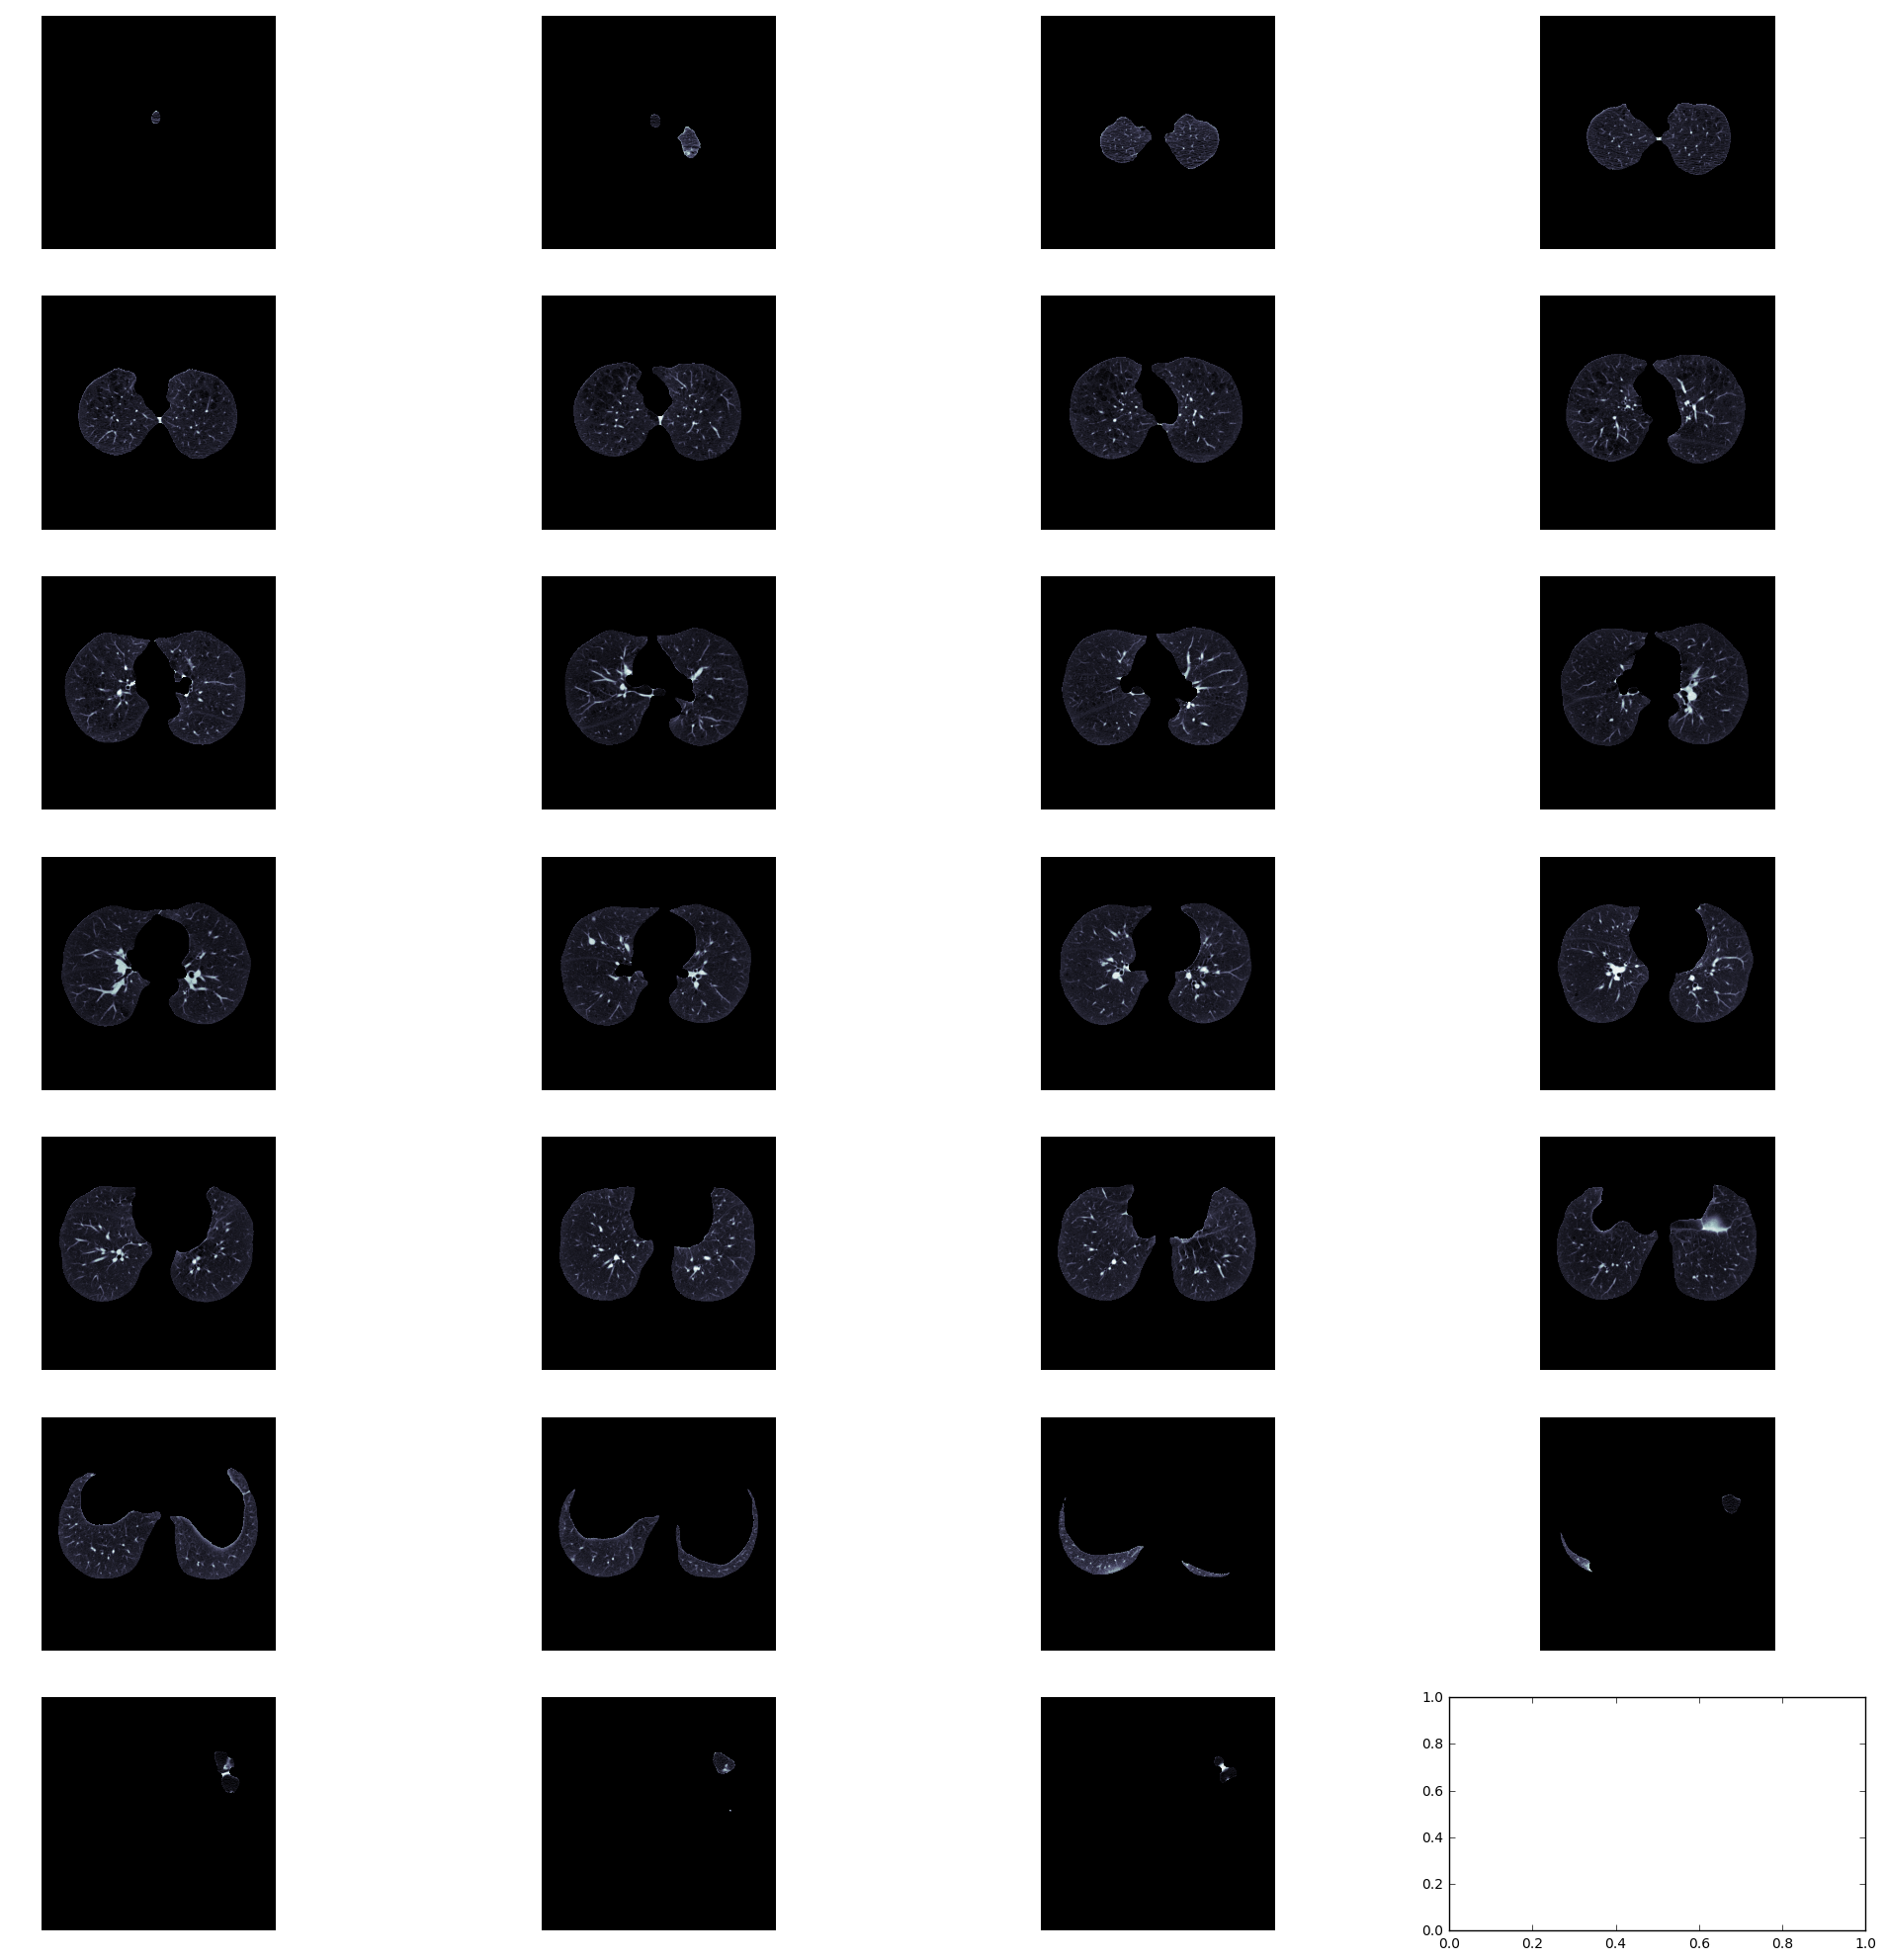

In [9]:
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
plot_ct_scan(segmented_ct_scan)

Nodule Candidate/Region of Interest Generation
---------------------------
After segmenting the lung structures from the CT Scanned images, our task is to find the candidate regions with nodules. It was found in experiments that all the region of interests have intensity >  604(-400 HU). So, we used to this threshold to filter the regions. 

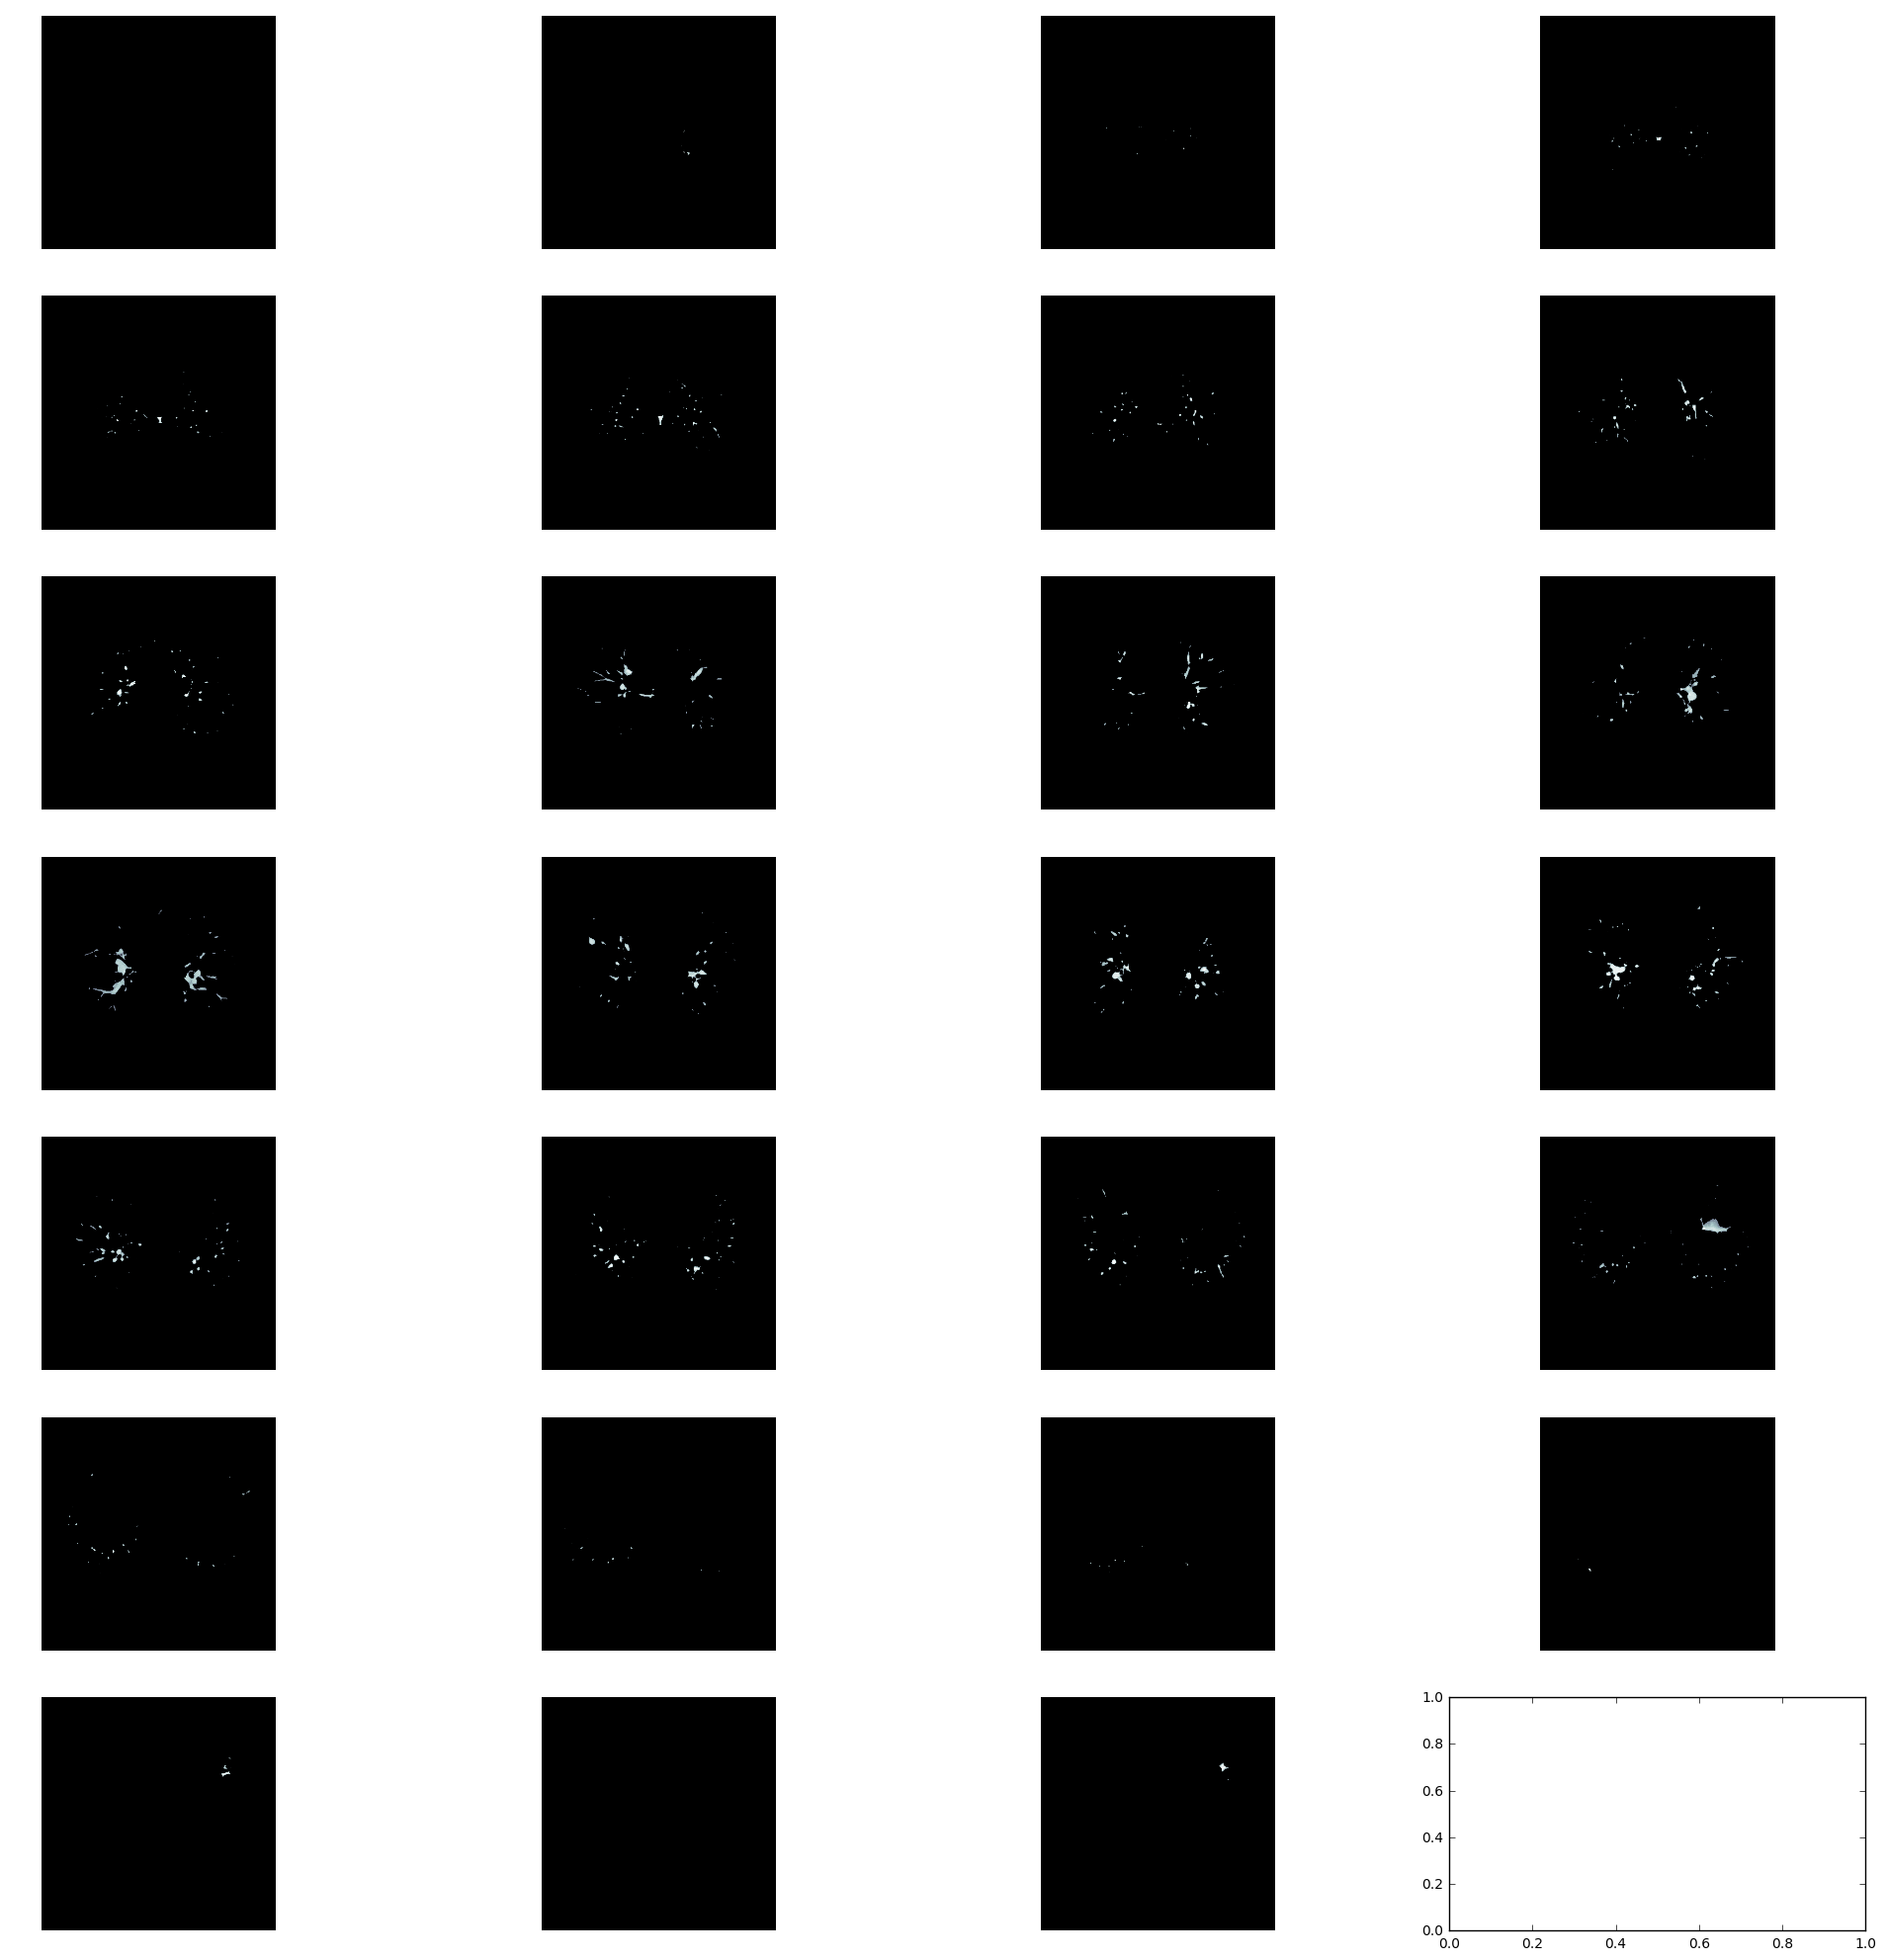

In [10]:
segmented_ct_scan[segmented_ct_scan < 604] = 0
plot_ct_scan(segmented_ct_scan)

After filtering, there are still lot of noise because of blood vessels. Thus we further remove the two largest connected component.

In [11]:
selem = ball(2)
binary = binary_closing(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
            segmented_ct_scan[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

In [12]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

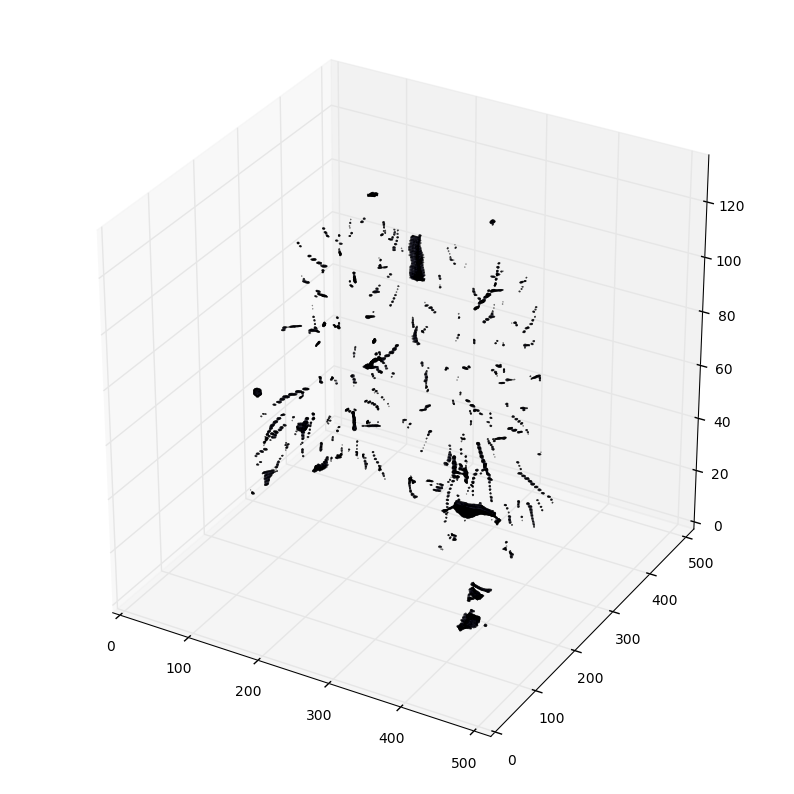

In [13]:
plot_3d(segmented_ct_scan, 604)

There are more methods that can be tried to get the regions of interest.

 1.  The left blood vessels can further be filtered using shape properties because we know that nodules are spherical in shape.
 2. Super pixel segmentation can be further used and shape properties can be applied on segmented regions.
 3. CNN architectures like UNet can also be used to generate candidate regions of interest. 

Next I will be discussing about preprocessing of the LUNA16 dataset and using it to train the UNet model.

UNET for Candidate Point Generation
-----------------------------------

Nowadays, Deep Learning methods are achieving good results in Segmentation problems in medical imaging. One very famous architecture is UNET, which can be used for Nodule Candidates Points Generation in our case. Training of these networks is done using annotated datasets. The image processing methods used for candidate points generation above does not need any training data. We use the LUNA16 dataset for training our UNET model. 

In the LUNA16 dataset, each CT Scan is annotated with nodule points and the radius of the nodule which is used to generate the binary mask.  I will first talk about preprocessing of the LUNA16 dataset. In the dataset, the CT Scans are saved in '.mhd' files and SimpleITK is used to read the image.  I have defined three functions:

 - **load_itk** - Used to read a CT_Scan for the '.mhd' file.
 - **world_2_voxel**- Convert world coordinates to voxel coordinates.
 - **voxel_2_world**- Convert voxel coordinates to world coordinates.

In [14]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

After reading the 3D CT Scans, we will first segment the lungs and then generate the binary mask of nodule regions. This will be done by the `create_nodule_mask` function.  The `draw_circle` function is used to mark the nodule regions in the binary mask. 'cands' are the list of nodule points with the radius given in the `annotation.csv` file of LUNA16 dataset. At the end we save the resized CT Scan with its segmented lungs and binary mask of nodules.

In [15]:
def seq(start, stop, step=1):
	n = int(round((stop - start)/float(step)))
	if n > 1:
		return([start + step*i for i in range(n+1)])
	else:
		return([])

'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
	#make empty matrix, which will be filled with the mask
	image_mask = np.zeros(image.shape)

	#run over all the nodules in the lungs
	for ca in cands.values:
		#get middel x-,y-, and z-worldcoordinate of the nodule
		radius = np.ceil(ca[4])/2
		coord_x = ca[1]
		coord_y = ca[2]
		coord_z = ca[3]
		image_coord = np.array((coord_z,coord_y,coord_x))

		#determine voxel coordinate given the worldcoordinate
		image_coord = world_2_voxel(image_coord,origin,spacing)

		#determine the range of the nodule
		noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

		#create the mask
		for x in noduleRange:
			for y in noduleRange:
				for z in noduleRange:
					coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
					if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
						image_mask[np.round(coords[0]),np.round(coords[1]),np.round(coords[2])] = int(1)
	
	return image_mask

'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, maskPath, cands):
	#if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
	img, origin, spacing = load_itk(imagePath)

	#calculate resize factor
	resize_factor = spacing / [1, 1, 1]
	new_real_shape = img.shape * resize_factor
	new_shape = np.round(new_real_shape)
	real_resize = new_shape / img.shape
	new_spacing = spacing / real_resize
	
	#resize image
	lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
	lung_img = lung_img + 1024
	lung_mask = segment_lung_from_ct_scan(lung_img)
	lung_img = lung_img - 1024

	#create nodule mask
	nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

	lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

	original_shape = lung_img.shape	
	for z in range(lung_img.shape[0]):
		offset = (512 - original_shape[1])
		upper_offset = np.round(offset/2)
		lower_offset = offset - upper_offset

		new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

		lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
		lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
		nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
	np.save(imageName + '_lung_img.npz', lung_img_512)
	np.save(imageName + '_lung_mask.npz', lung_mask_512)
	np.save(imageName + '_nodule_mask.npz', nodule_mask_512)
        

After preprocessing the dataset, the next thing is to train the model for segmentation. The model is written in keras in the `unet_model` function. It takes a 2D slice as input and returns a 2D slice of the same size as output. There are few things to be kept in mind while training

 - We wont use the slices that has no nodule region in the mask for training.
 - Dataset augmentation is very important because are nodules are generally circular or spherical in shape and are of different radius. 
 - Since the nodule regions are very less, the dataset is skewed. Thus, we should weight the loss function accordingly.
 - The model may overfit on the training dataset. Thus, Dropout or Spatial Dropout are used to avoid overfitting.

In [16]:
# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
	y_pred_f = K.flatten(y_pred)
	intersection = K.sum(y_true_f * y_pred_f)
	return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
	return -dice_coef(y_true, y_pred)

'''
The UNET model is compiled in this function.
'''
def unet_model():
	inputs = Input((1, 512, 512))
	conv1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(inputs)
	conv1 = Dropout(0.2)(conv1)
	conv1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv1)
	pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

	conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool1)
	conv2 = Dropout(0.2)(conv2)
	conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv2)
	pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

	conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool2)
	conv3 = Dropout(0.2)(conv3)
	conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv3)
	pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

	conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool3)
	conv4 = Dropout(0.2)(conv4)
	conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv4)
	pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

	conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')(pool4)
	conv5 = Dropout(0.2)(conv5)
	conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')(conv5)

	up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
	conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(up6)
	conv6 = Dropout(0.2)(conv6)
	conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv6)

	up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
	conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up7)
	conv7 = Dropout(0.2)(conv7)
	conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv7)

	up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
	conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up8)
	conv8 = Dropout(0.2)(conv8)
	conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv8)

	up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
	conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up9)
	conv9 = Dropout(0.2)(conv9)
	conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv9)

	conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

	model = Model(input=inputs, output=conv10)
	model.summary()
	model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

	return model

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-16-90430b198ede>, line 5)

I will post the dataset augmentation functions and Spatial Dropout very soon. I will post more methods as soon I implement them.

After getting the regions of interest, 3D voxels can be cut around regions of interest and used for classification.

**Please upvote or leave a comment, if you liked the tutorial.**